# Matlab testbench model state-space matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
import opentorsion as ot
import cvxpy as cp

In [2]:
plt.style.use(['science', 'ieee'])
plt.rcParams["figure.figsize"] = (6,4)

In [3]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [4]:
time_steps = np.genfromtxt('../data/ice_excitation/times.csv', delimiter=',')
motor = np.genfromtxt('../data/ice_excitation/motor.csv', delimiter=',')
propeller = np.genfromtxt('../data/ice_excitation/propeller.csv', delimiter=',')
angular_speeds = np.genfromtxt('../data/ice_excitation/speed_measurements.csv', delimiter=',')
shaft_torque = np.genfromtxt('../data/ice_excitation/torque_measurements.csv', delimiter=',')

In [5]:
A_mat = np.genfromtxt('../data/testbench_A.csv', delimiter=',')
B_mat = np.genfromtxt('../data/testbench_B.csv', delimiter=',')
C_mat = np.genfromtxt('../data/testbench_C.csv', delimiter=',')
D_mat = np.genfromtxt('../data/testbench_D.csv', delimiter=',')

ts = np.mean(np.diff(time_steps))
A_mat_d, B_mat_d = c2d(A_mat, B_mat, ts)

# Input and state estimation functions

In [6]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [7]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

In [8]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    input_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

In [9]:
def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)
    
    # delete incomplete rows
    D2 = D2[:-2*m, :]
    
    return D2

In [10]:
def tikhonov_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a Tikhonov regularization problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    #x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    
    if initial_state is not None:
        x = initial_state
    else:        
        x = np.zeros((obsrv.shape[1], 1))
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    
    prob = cp.Problem(objective)
    prob.solve()

    return d.value, x#.value

In [11]:
def lasso_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a LASSO problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    #x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    
    if initial_state is not None:
        x = initial_state
    else:        
        x = np.zeros((obsrv.shape[1], 1))
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))
    
    prob = cp.Problem(objective)
    prob.solve()

    return d.value, x#.value

# TODO: Input and state estimation with laboratory testbench measurments

## Load and preprocess data
* motor sampling rate ~1kHz
* sensor sampling rate ~3kHz

In [12]:
# time | MotorVelocitySet | MotorVelocity | MotorTorqueSet | MotorTorque | PropellerVelocitySet | PropellerVelocity | PropellerTorqueSet | PropellerTorque
#m_data = np.genfromtxt('../data/testbench_data/motor/baseline_500rpm_Constant_Torque_1%_motor_GP1.csv', delimiter=',')
#motor_data = np.delete(m_data, 0, 0) # delete header row

# time | enc1_ang | enc1_time | enc2_ang | enc2_time | enc3_ang | enc3_time | enc4_ang | enc4_time | enc5_ang | enc5_time | acc1 | acc2 | acc3 | acc4 | Torq1 | Torq2
#s_data = np.genfromtxt('../data/testbench_data/sensor/baseline_500rpm_Constant_Torque_1%_GP1.csv', delimiter=',')
#sensor_data = np.delete(s_data, 0, 0) # delete header row

In [13]:
# time | MotorTorqueSet | MotorTorque | MotorVelocitySet | MotorVelocity | PropellerTorqueSet | PropellerTorque | PropellerVelocitySet | PropellerVelocity
m_data = np.genfromtxt('../data/testbench_data/motor/baseline_500rpm_Sin_torque_11%_motor_GP1.csv', delimiter=',')
motor_data = np.delete(m_data, 0, 0) # delete header row

# time | enc1_ang | enc1_time | enc2_ang | enc2_time | enc3_ang | enc3_time | enc4_ang | enc4_time | enc5_ang | enc5_time | acc1 | acc2 | acc3 | acc4 | Torq1 | Torq2
s_data = np.genfromtxt('../data/testbench_data/sensor/baseline_500rpm_Sin_Torque_11%_GP1.csv', delimiter=',')
sensor_data = np.delete(s_data, 0, 0) # delete header row

In [14]:
t_motor = motor_data[:,0]
tau_motor = motor_data[:,2]
tau_propeller = motor_data[:,6]

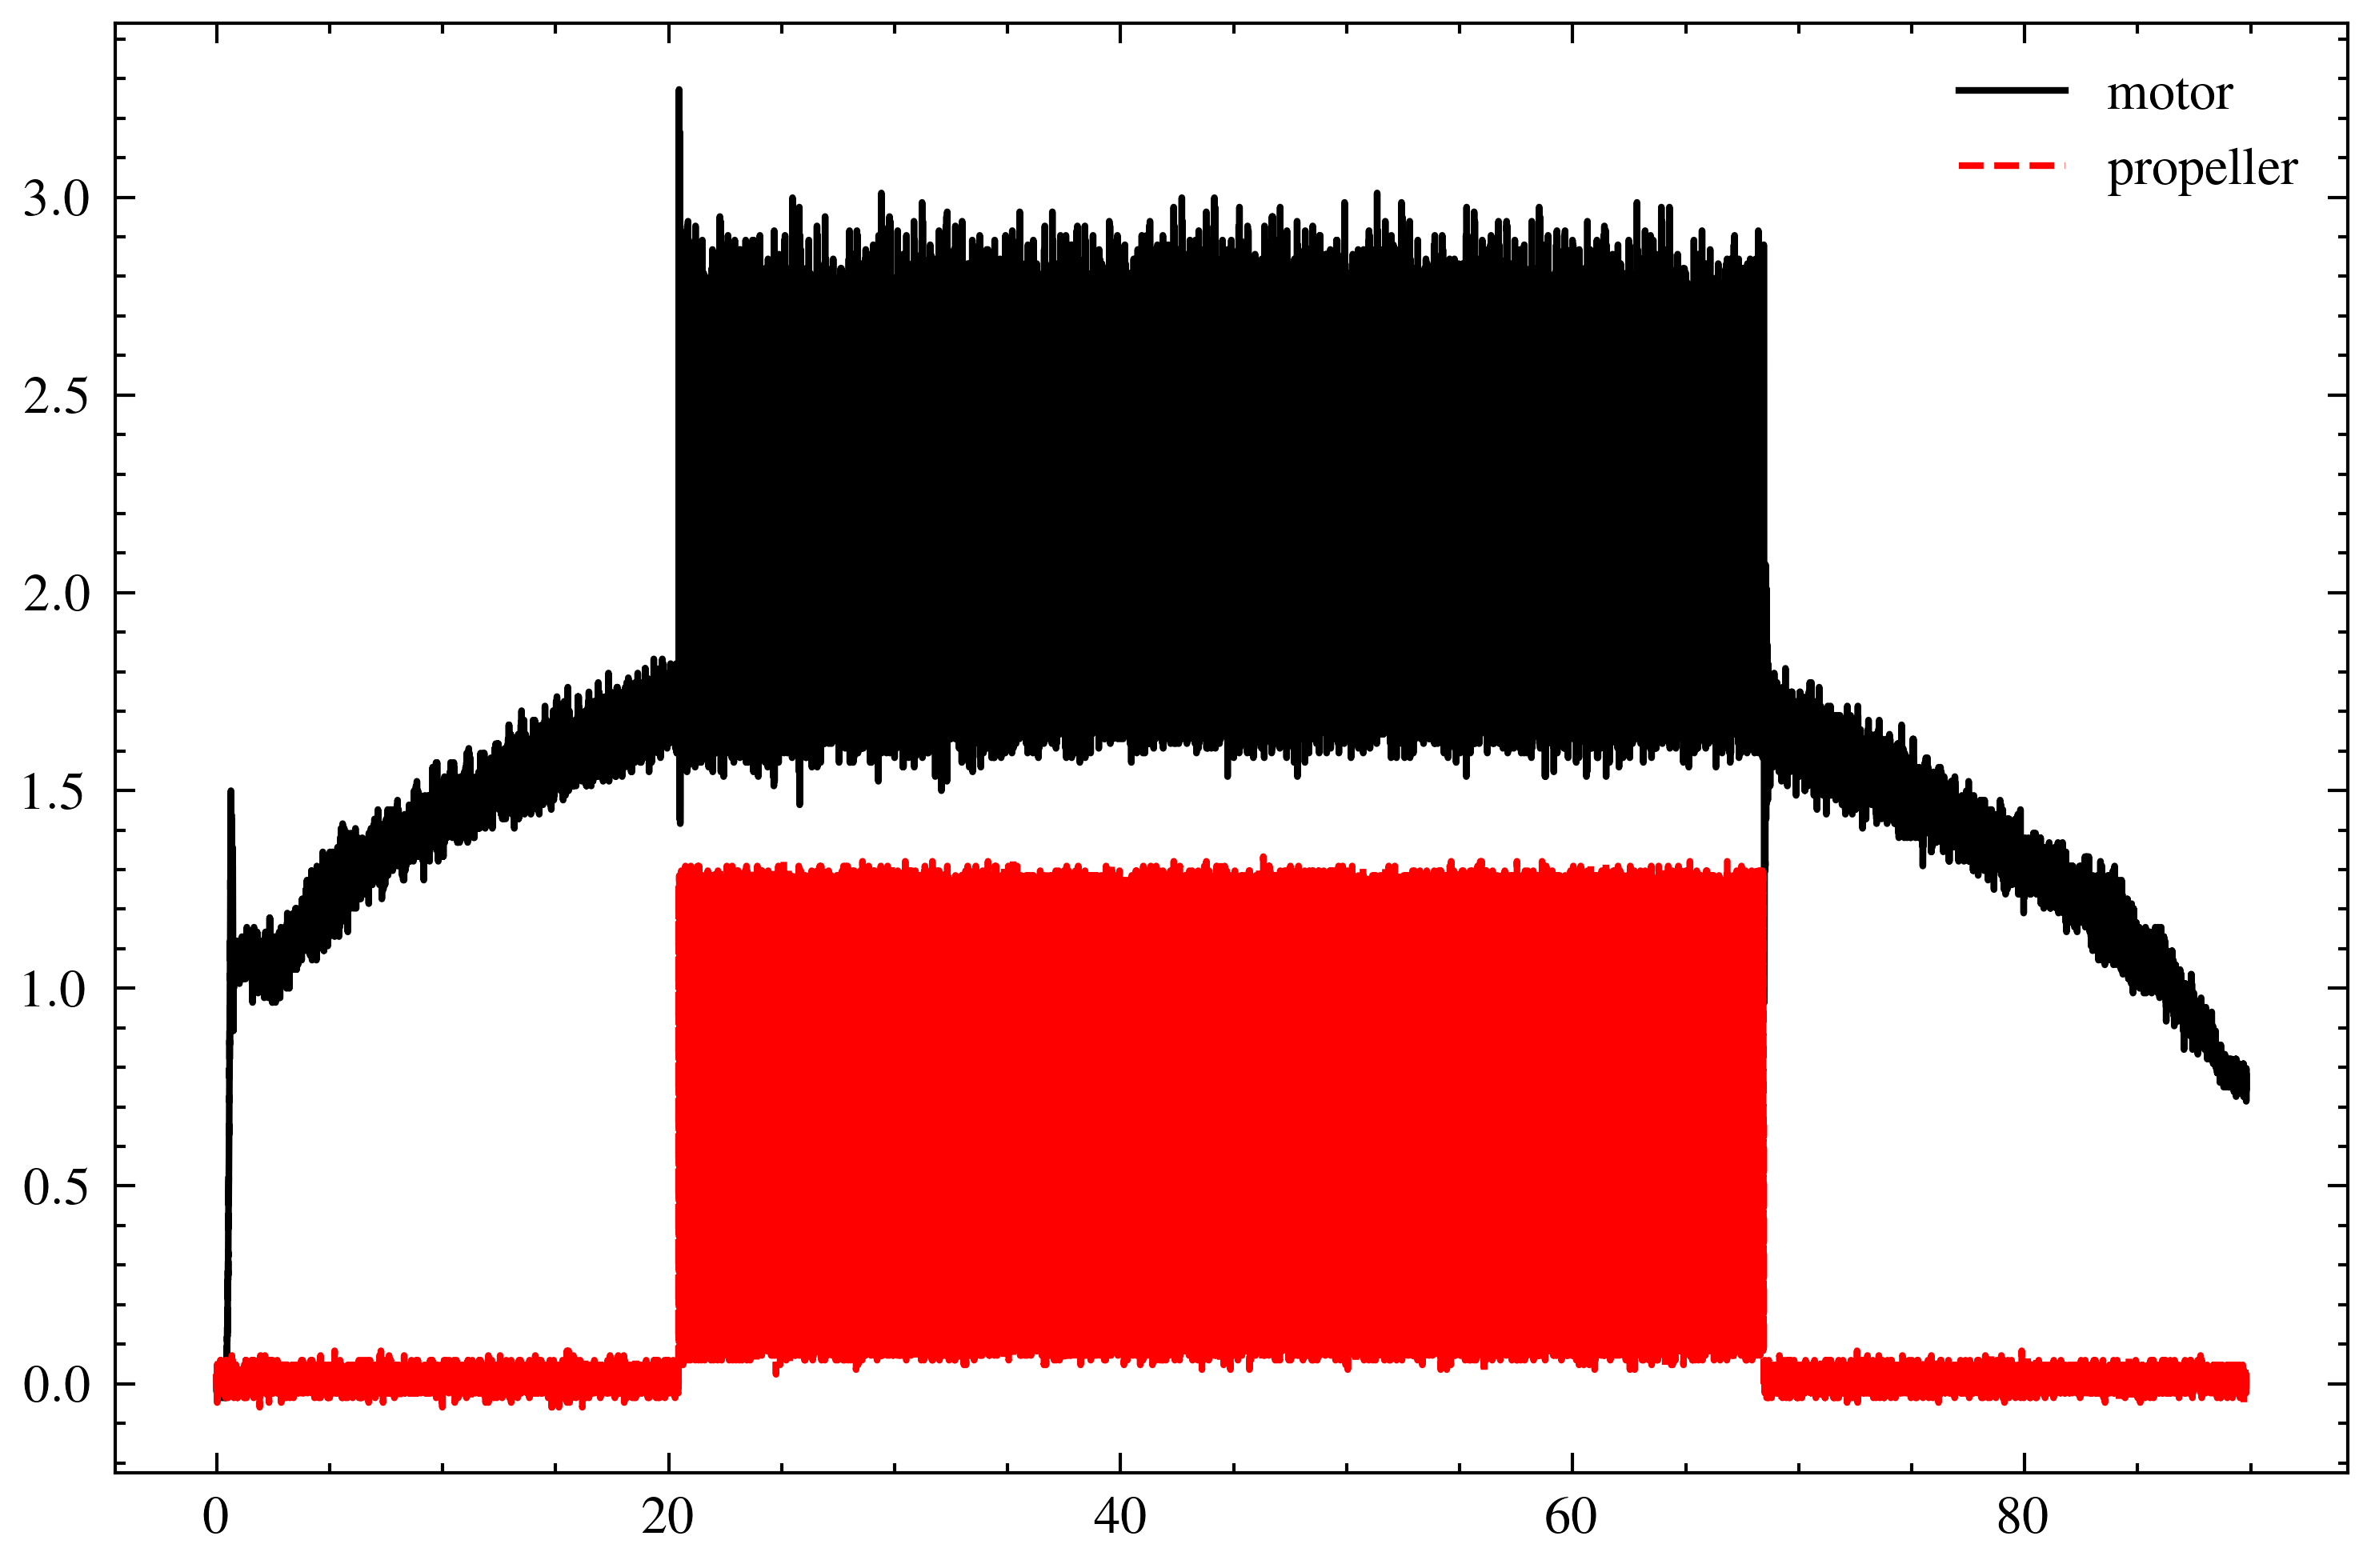

In [15]:
plt.plot(t_motor, tau_motor, label='motor')
plt.plot(t_motor, tau_propeller, label='propeller')
plt.legend()
plt.show()

In [16]:
# motor sampling rate is ~1/3 of sensor sampling rate so every third sensor sample is used
t_sensor = sensor_data[:,0]
i_max = len(t_sensor) - (len(t_sensor) % len(t_motor))
sensor_tmp = sensor_data[:i_max,:] # len(sensor_data) == 3*len(motor_data)
sensor_data_third = sensor_tmp[::3,:] # len(sensor_data) == len(motor_data)

In [17]:
t_sensor_third = sensor_data_third[:,0]
torq_sensor1 = sensor_data_third[:,-2]
torq_sensor2 = sensor_data_third[:,-1]

/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1073: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1074: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1075: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:1075: RuntimeWarning: invali

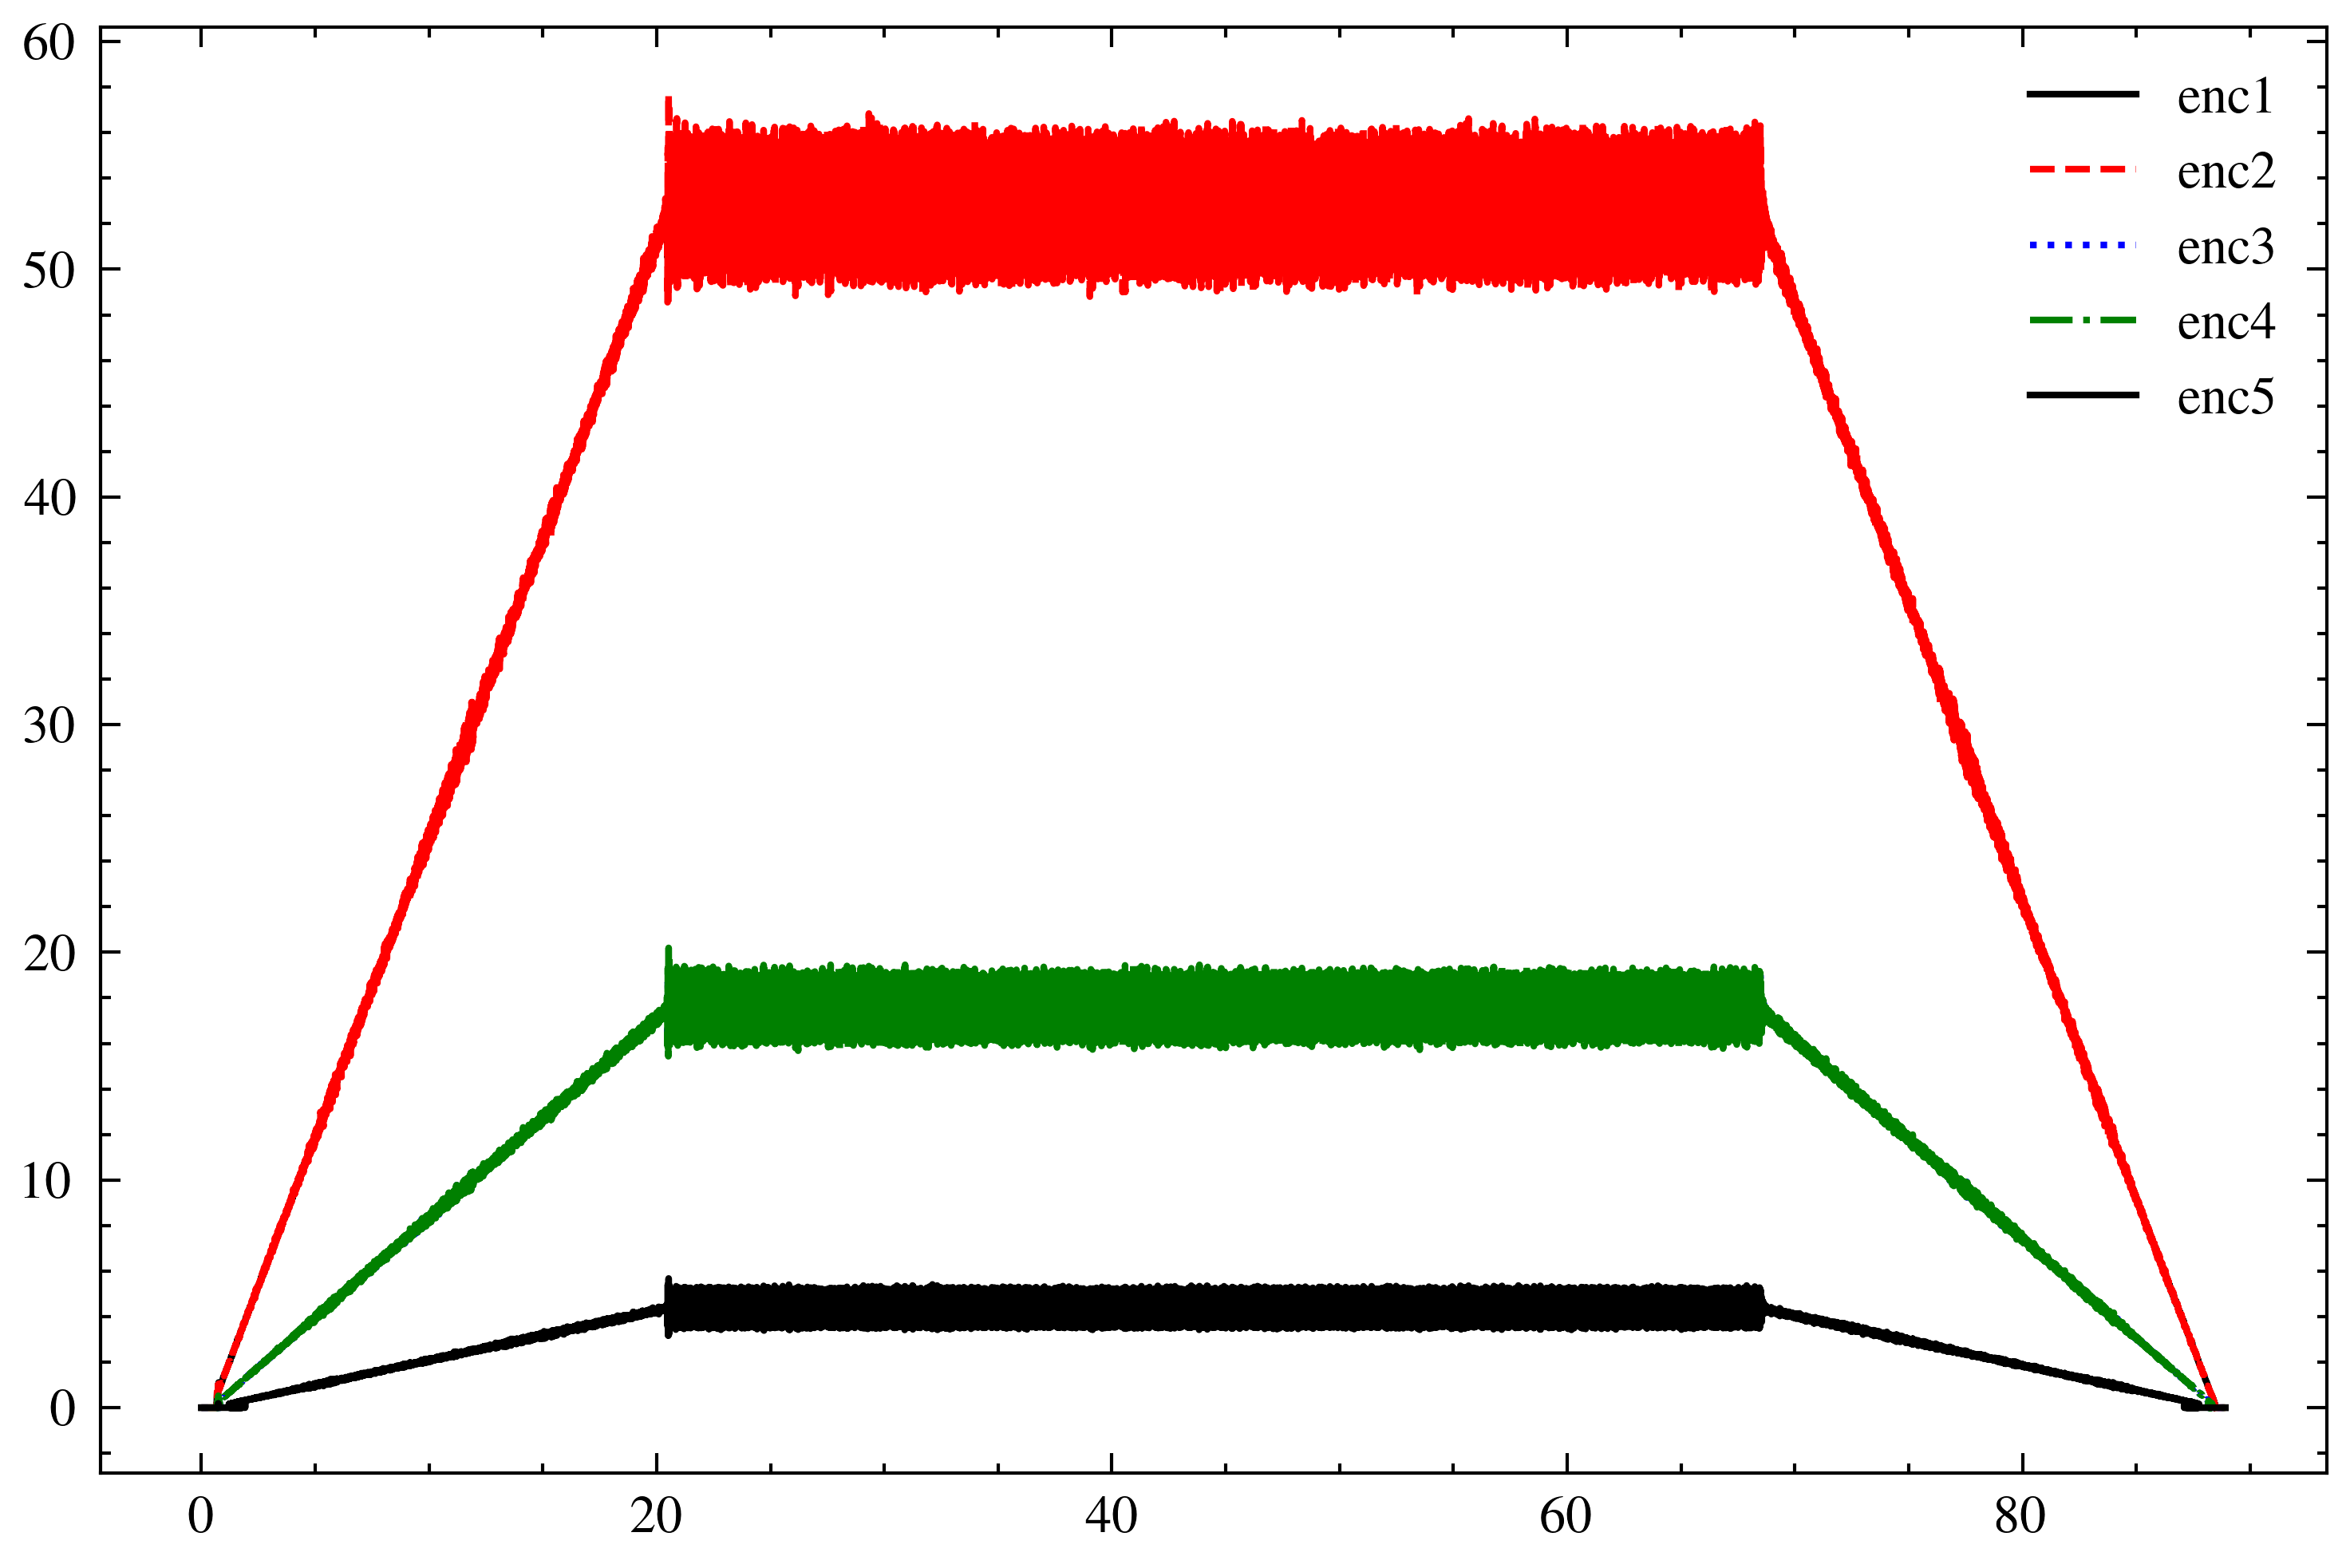

In [18]:
omega1 = np.gradient(sensor_data_third[:,1]*(np.pi/180), sensor_data_third[:,2])
omega2 = np.gradient(sensor_data_third[:,3]*(np.pi/180), sensor_data_third[:,4])
omega3 = np.gradient(sensor_data_third[:,5]*(np.pi/180), sensor_data_third[:,6])
omega4 = -np.gradient(sensor_data_third[:,7]*(np.pi/180), sensor_data_third[:,8])
omega5 = np.gradient(sensor_data_third[:,9]*(np.pi/180), sensor_data_third[:,10])
omega1[np.isnan(omega1)] = 0
omega2[np.isnan(omega2)] = 0
omega3[np.isnan(omega3)] = 0
omega4[np.isnan(omega4)] = 0
omega5[np.isnan(omega5)] = 0
plt.plot(t_sensor_third, omega1, label='enc1')
plt.plot(t_sensor_third, omega2, label='enc2')
plt.plot(t_sensor_third, omega3, label='enc3')
plt.plot(t_sensor_third, omega4, label='enc4')
plt.plot(t_sensor_third, omega5, label='enc5')
plt.legend()
plt.show()

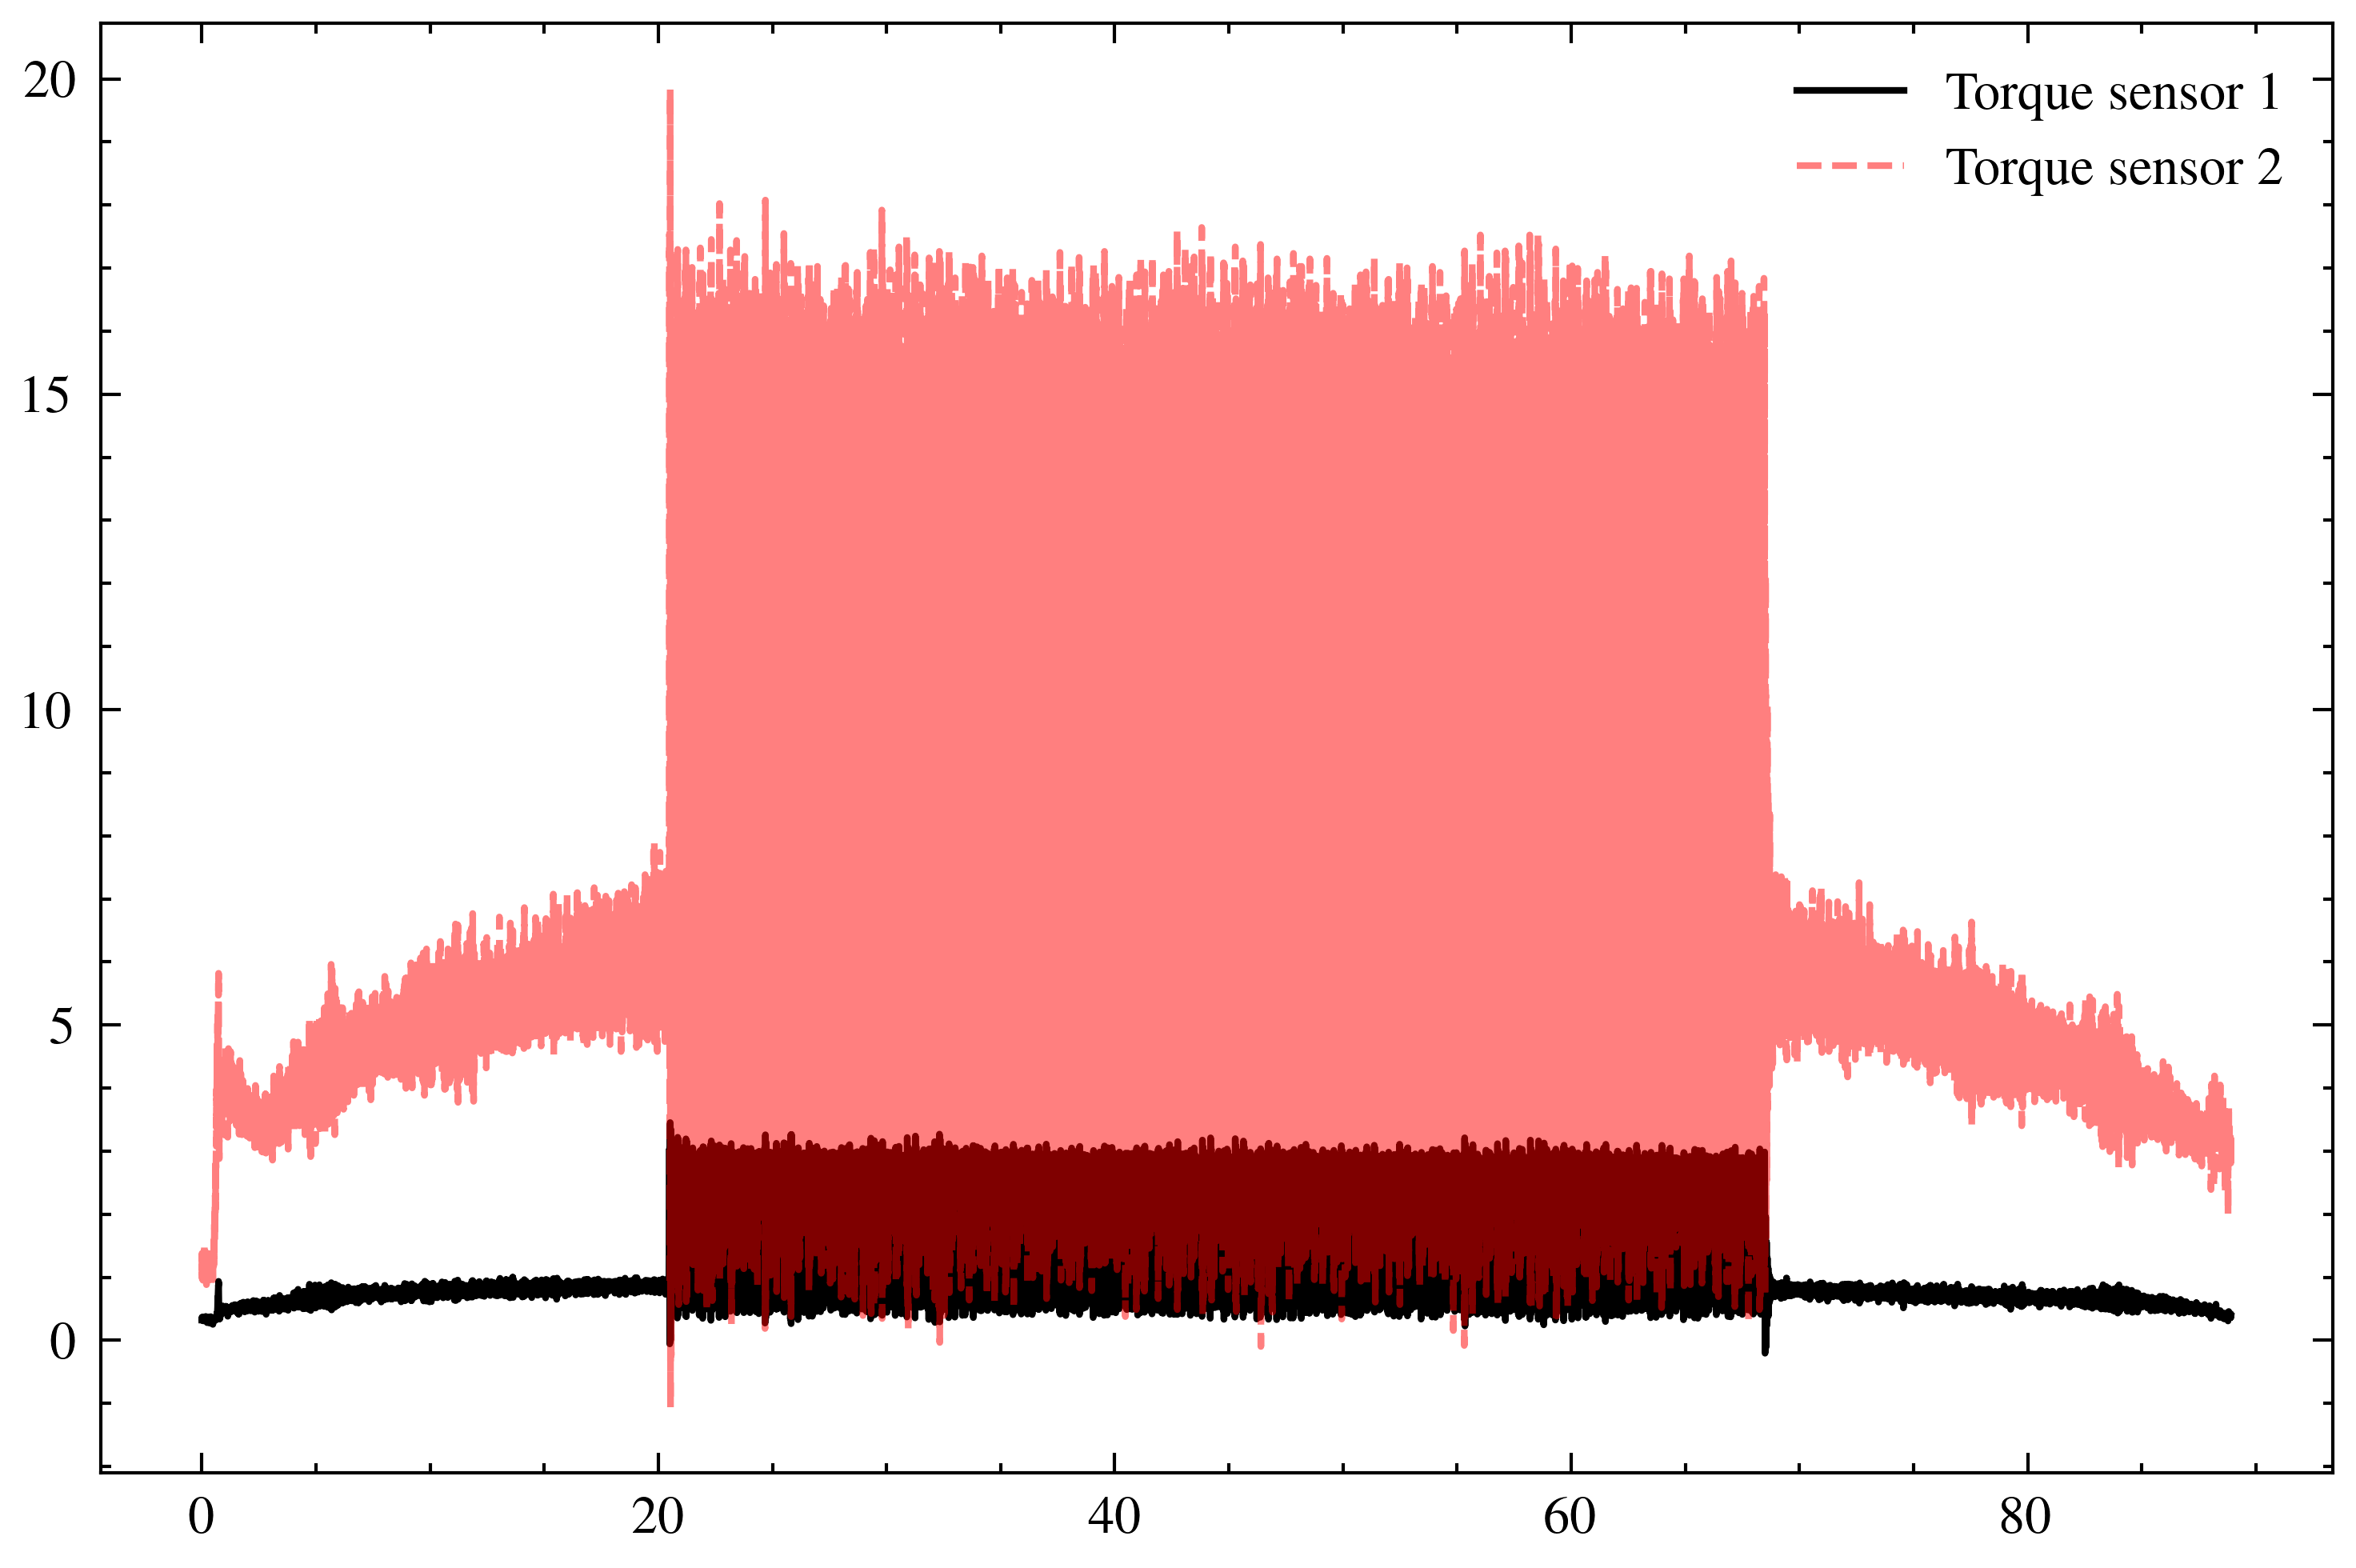

In [19]:
# torque sensor data is mixed up: V -> Nm conversion is redone
torq1 = (torq_sensor1/10)*4
torq2 = (torq_sensor2/4)*10

plt.plot(t_sensor_third, torq1, label='Torque sensor 1')
plt.plot(t_sensor_third, torq2, label='Torque sensor 2', alpha=0.5)
plt.legend()
plt.show()

## Input estimation

In [22]:
n = 1000 # number of measurements in the batch
k = 20000
m = B_mat_d.shape[1]

y = np.vstack((omega1[k:k+n], omega2[k:k+n], omega4[k:k+n], omega5[k:k+n], torq1[k:k+n], torq2[k:k+n]))
Y = np.reshape(y.T,(-1,1))

In [23]:
C_mat_d = np.zeros((6, B_mat_d.shape[0]))
C_mat_d[0,6] += 1 # enc 1
C_mat_d[1,7] += 1 # enc 2
C_mat_d[2,13] += 1 # enc 4
C_mat_d[3,14] += 1 # enc 5
C_mat_d[4,30] += 1 # torque 1
C_mat_d[5,40] += 1 # torque 2

#reg = L(m*n)
reg = second_difference_matrix(n, m)

observer = O(A_mat_d, C_mat_d, n)
gam = gamma(A_mat_d, B_mat_d, C_mat_d, n)

In [24]:
input_estimate, state_estimate = tikhonov_problem(Y, observer, gam, reg, lam=0.02)

In [25]:
if input_estimate is None: print('u_hat is ', u_hat)

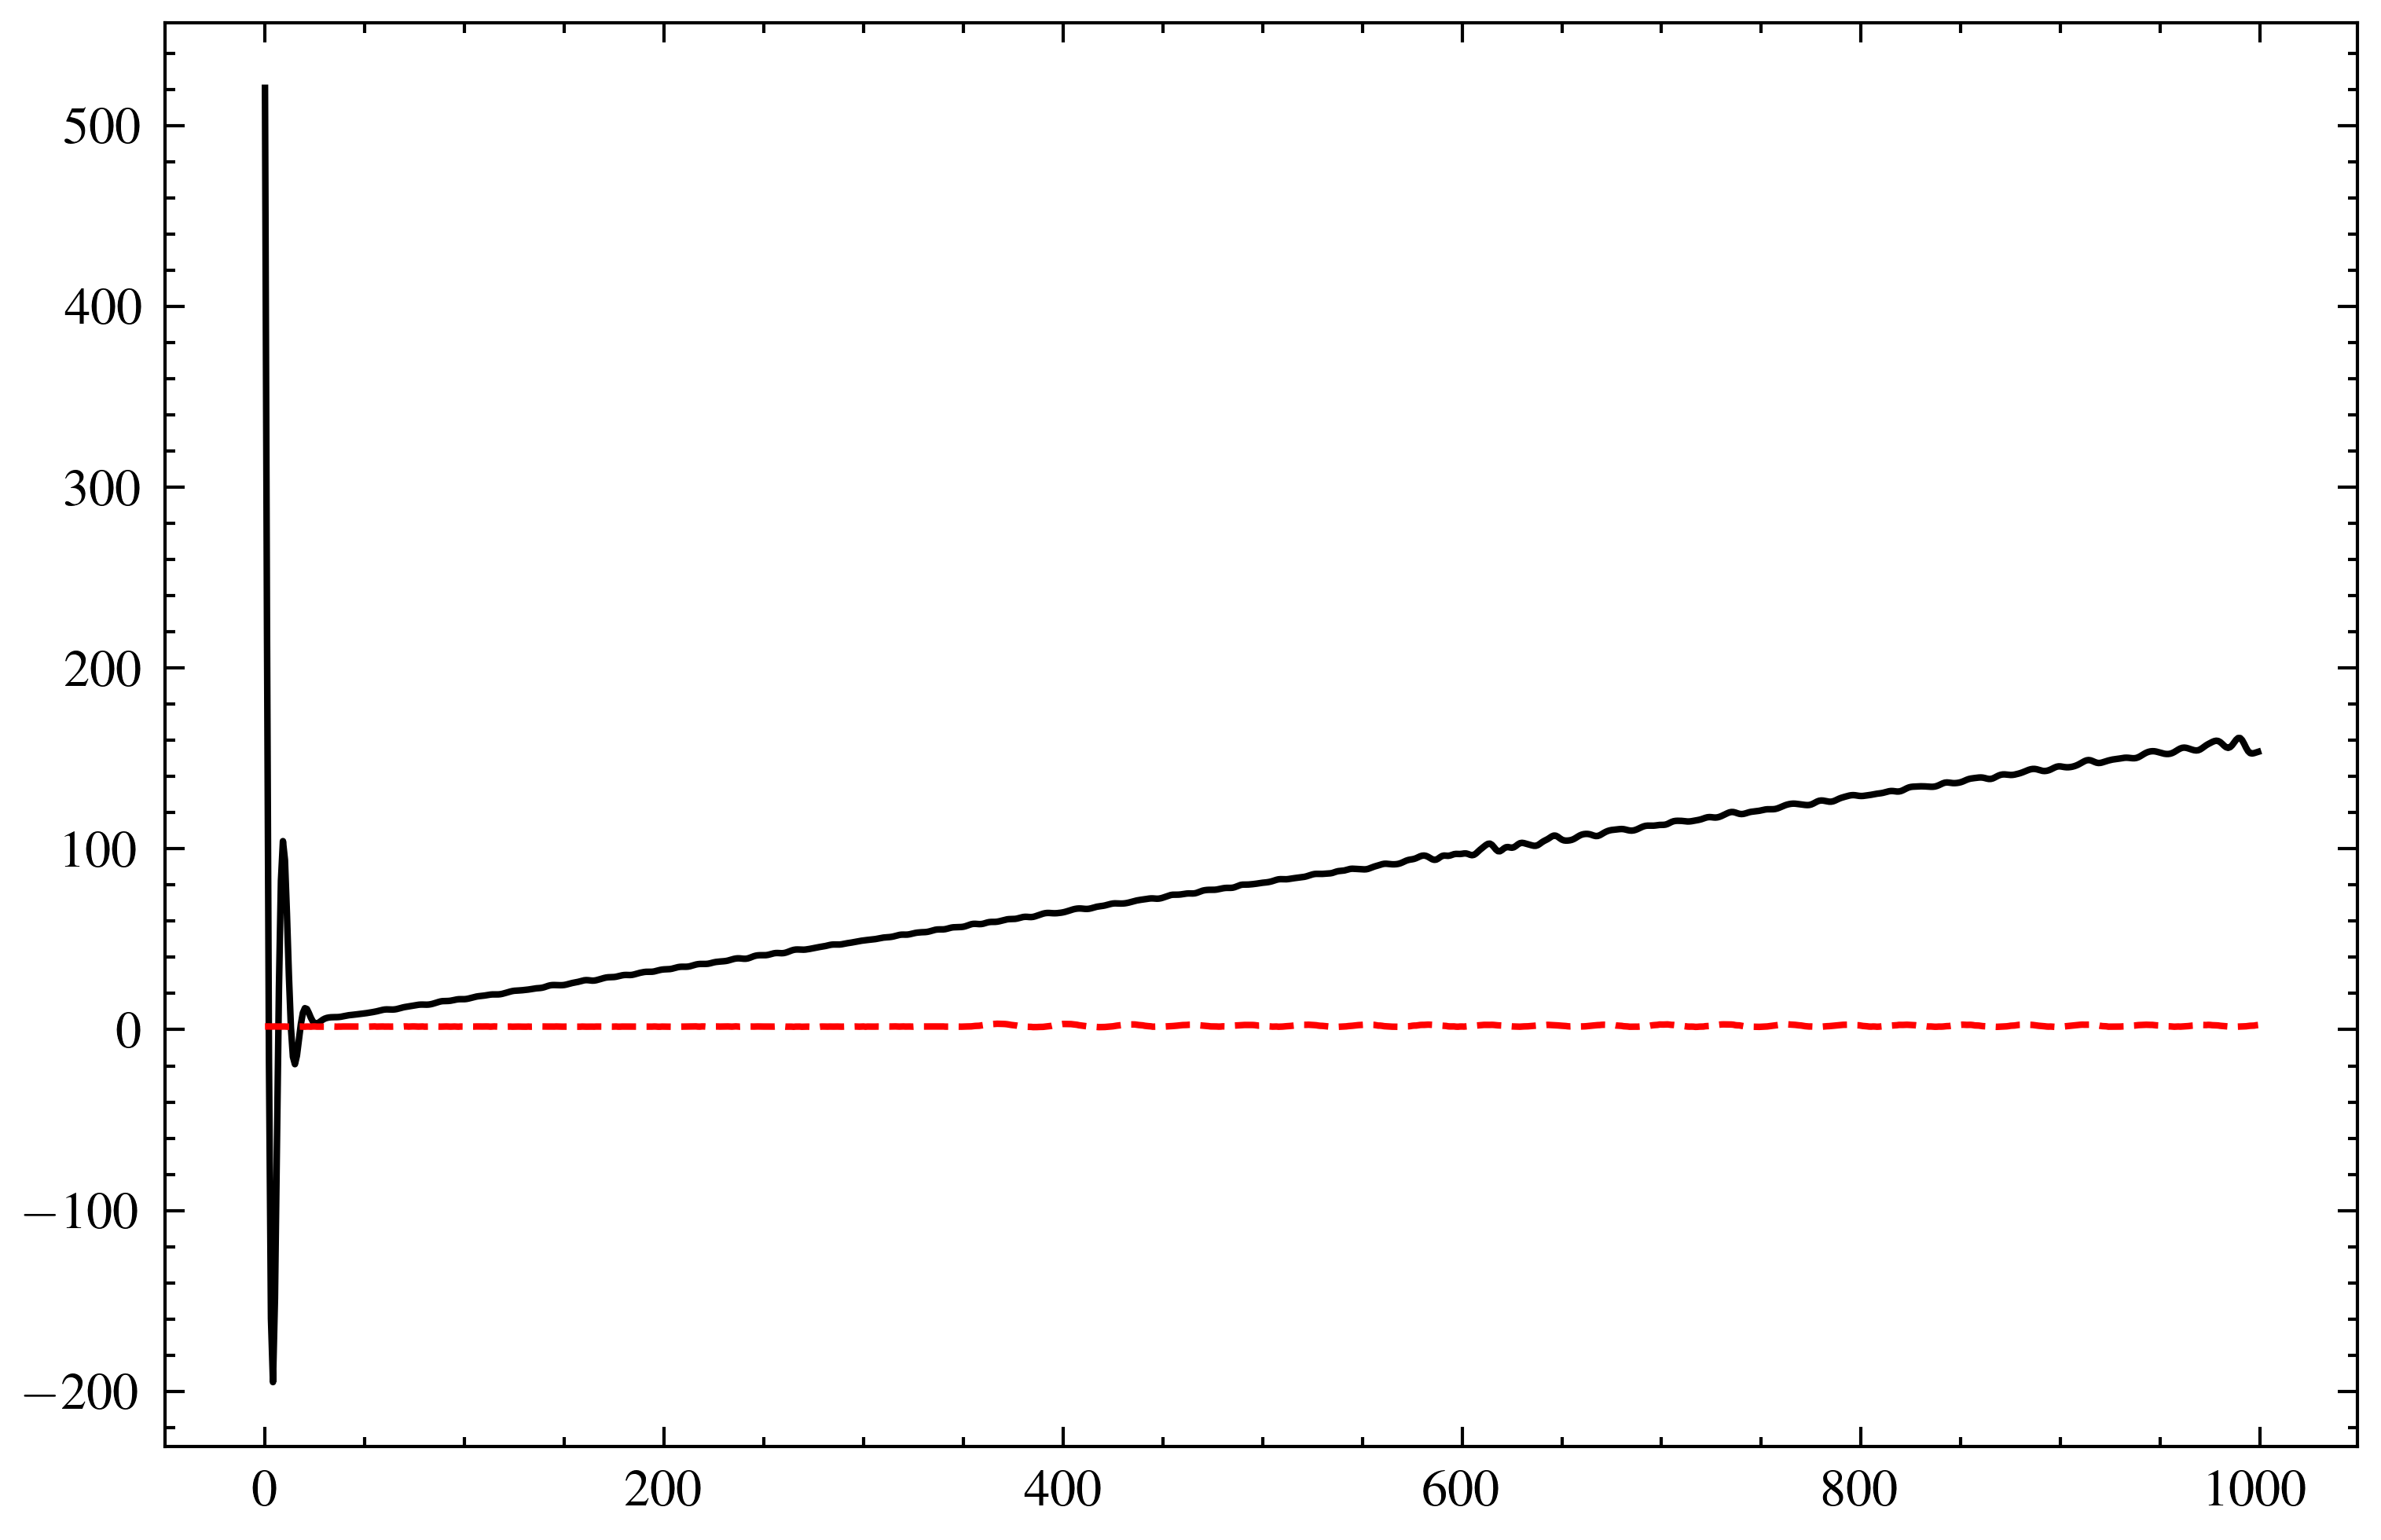

In [26]:
plt.plot(input_estimate[::2])
plt.plot(tau_motor[k:k+n])

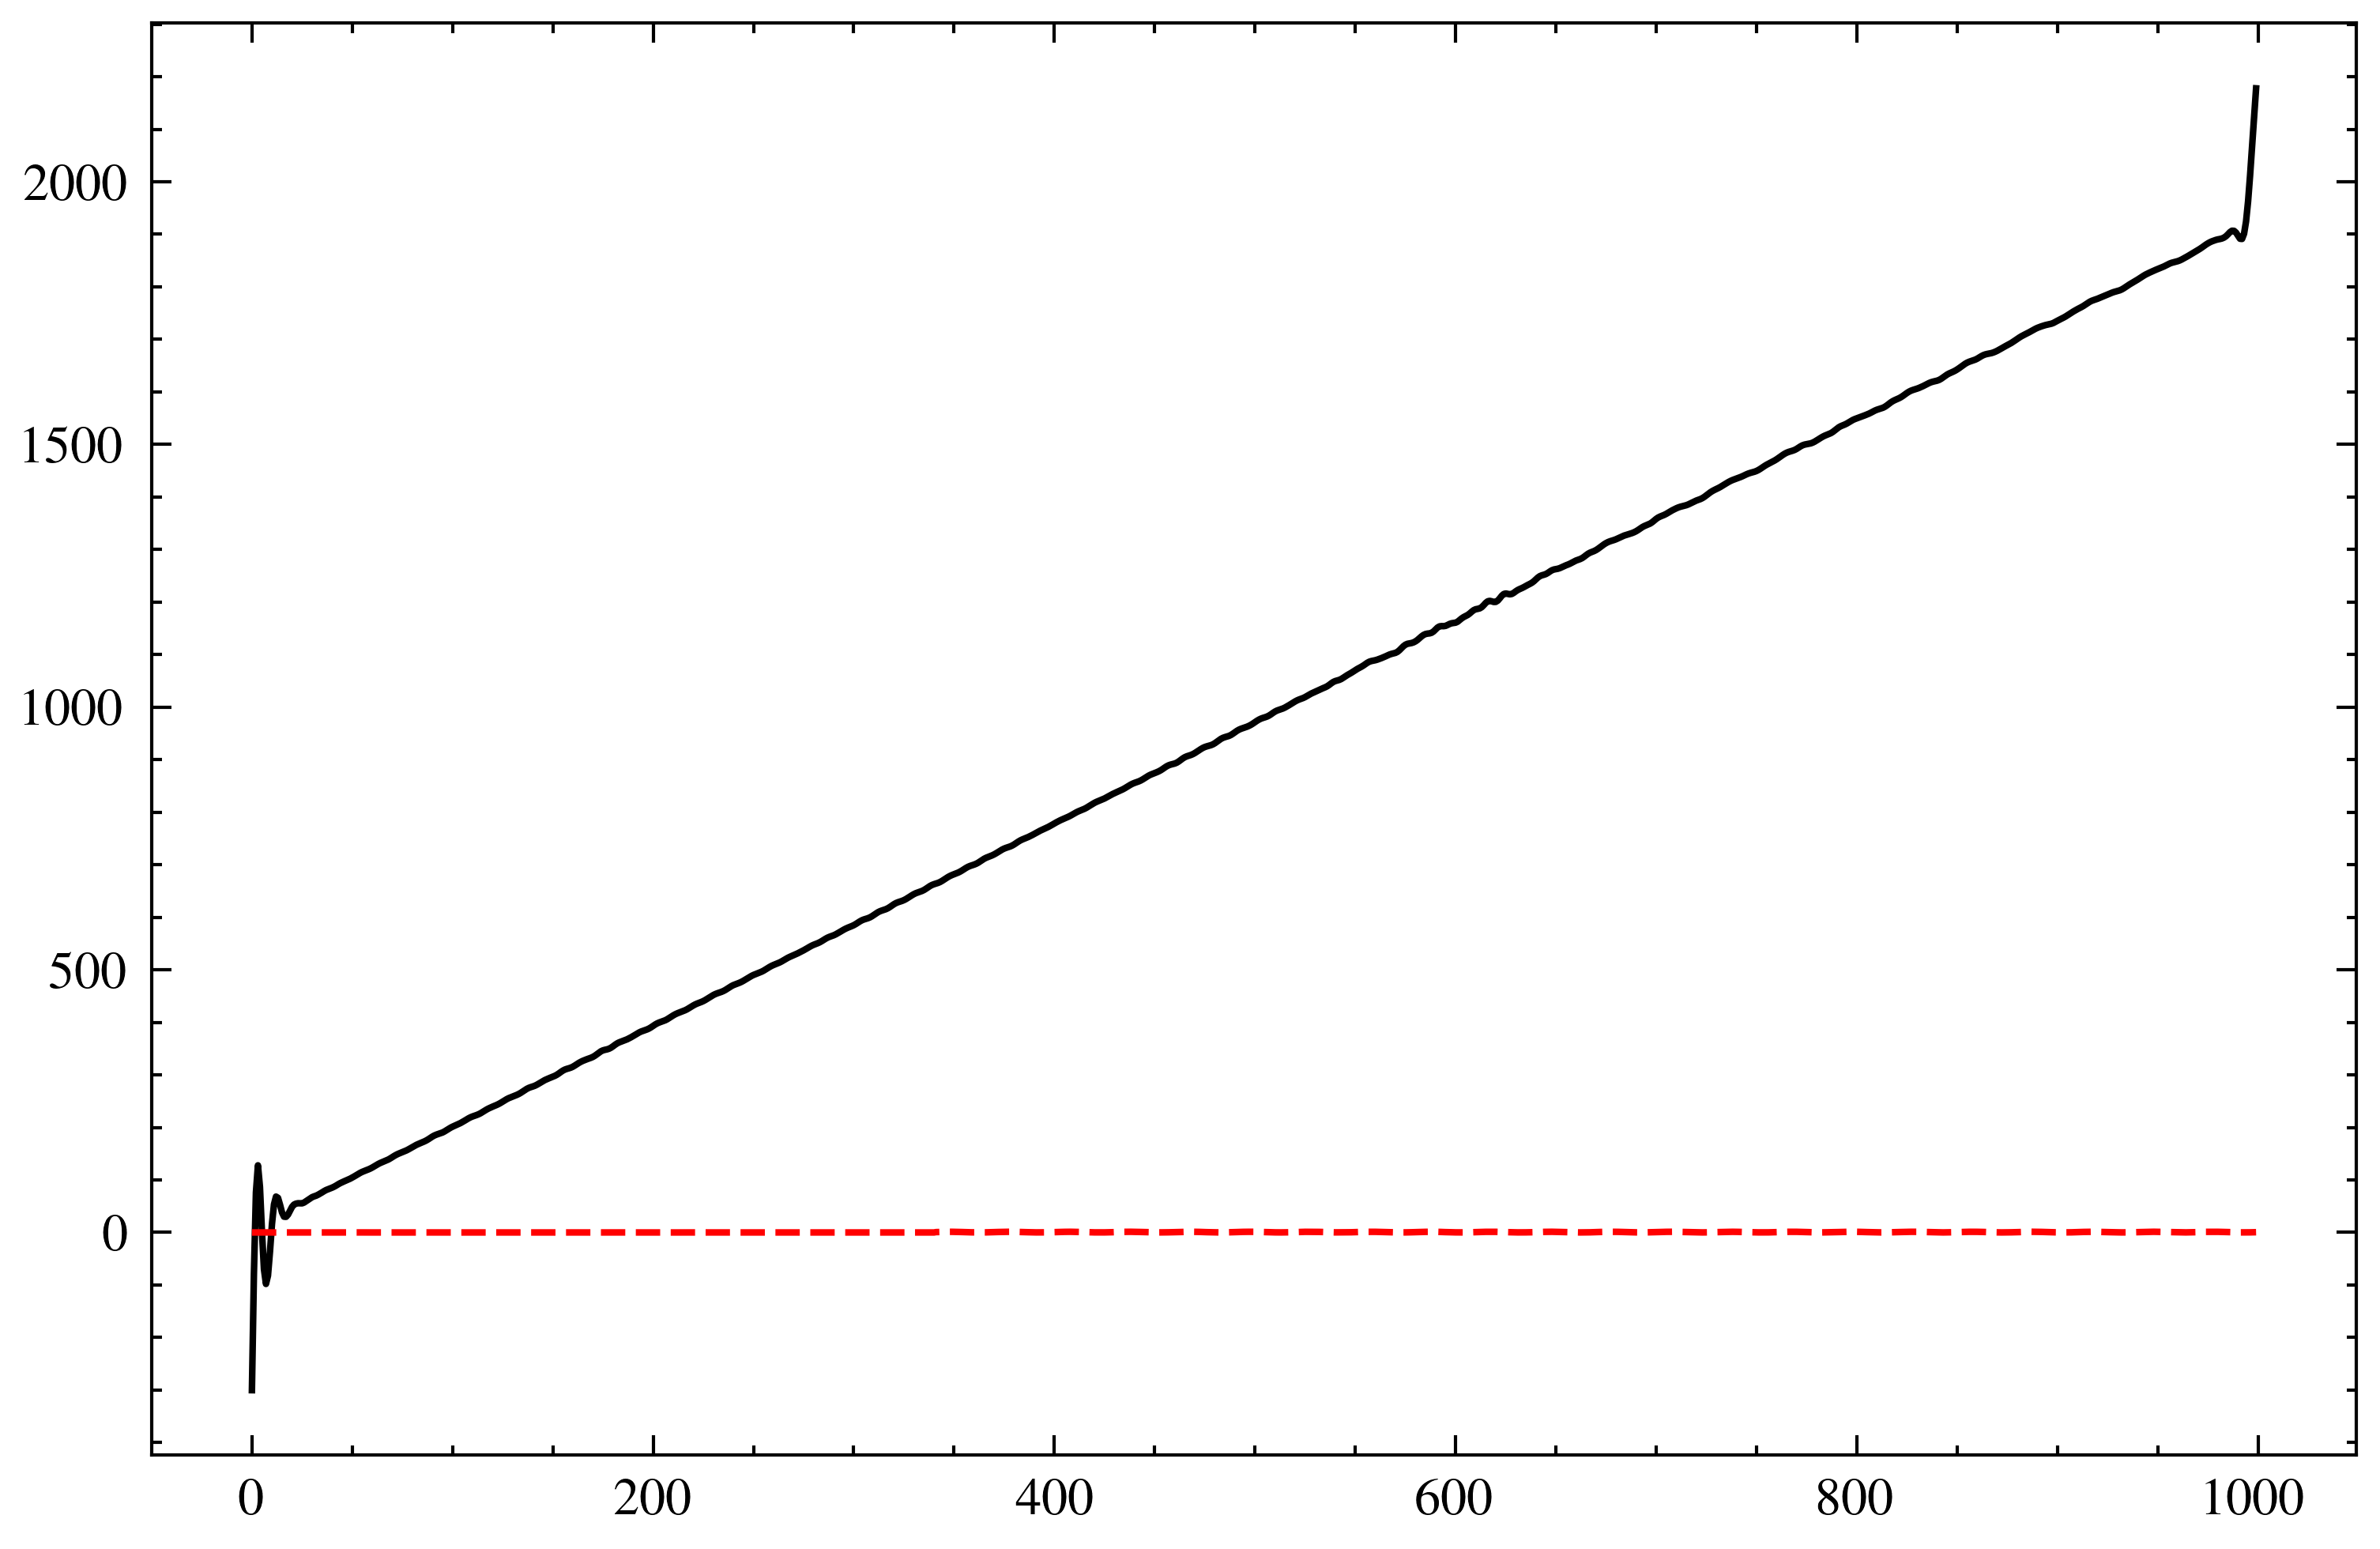

In [27]:
plt.plot(input_estimate[1::2])
plt.plot(tau_propeller[k:k+n])